⚠️ Notebook to visualize is available on [Google Colaboratory](https://colab.research.google.com/drive/1BCktqPLdYoWXeIdhiJW4Gp3jVk-dxGDD?usp=sharing).

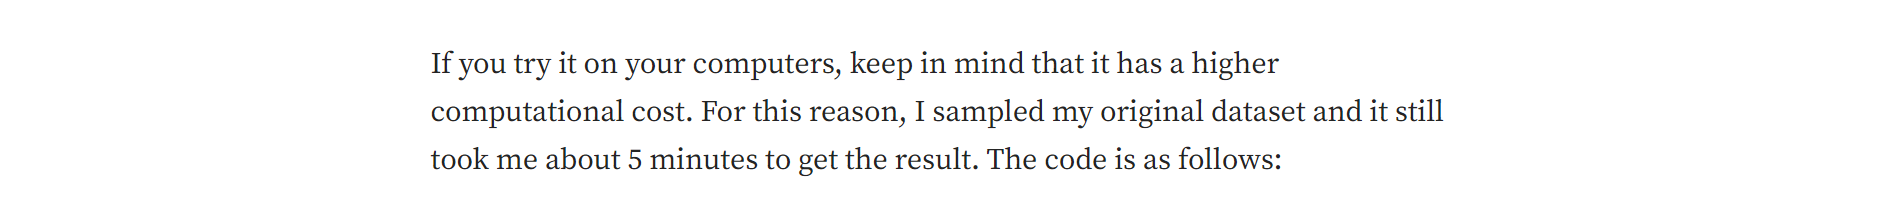

In [14]:
import pandas as pd
import numpy as np
import prince
import plotly.express as px
import lightgbm as lgb
import shap

from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

from sklearn.manifold import TSNE

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
data_no_outliers = pd.read_parquet('data/data_no_outliers.parquet')

data_no_outliers

cat_onehot__default_yes  cat_onehot__housing_yes  cat_onehot__loan_yes  \
0                          0.0                      1.0                   0.0   
1                          0.0                      1.0                   0.0   
2                          0.0                      1.0                   1.0   
3                          0.0                      1.0                   0.0   
4                          0.0                      1.0                   0.0   
...                        ...                      ...                   ...   
40685                      0.0                      0.0                   0.0   
40686                      0.0                      0.0                   1.0   
40687                      0.0                      0.0                   0.0   
40688                      0.0                      0.0                   0.0   
40689                      0.0                      0.0                   0.0   

       cat_onehot__job_blue-collar  cat_onehot__job_entrepreneur  \
0                              0.0                           0.0   
1                              0.0                           0.0   
2                              0.0                           1.0   
3                              1.0                           0.0   
4                              0.0                           0.0   
...                            ...                           ...   
40685                          0.0                           0.0   
40686                          0.0                           0.0   
40687                          0.0                           0.0   
40688                          1.0                           0.0   
40689                          0.0                           1.0   

       cat_onehot__job_housemaid  cat_onehot__job_management  \
0                            0.0                         1.0   
1                            0.0                         0.0   
2                            0.0                         0.0   
3                            0.0                         0.0   
4                            0.0                         1.0   
...                          ...                         ...   
40685                        0.0                         0.0   
40686                        0.0                         0.0   
40687                        0.0                         0.0   
40688                        0.0                         0.0   
40689                        0.0                         0.0   

       cat_onehot__job_retired  cat_onehot__job_self-employed  \
0                          0.0                            0.0   
1                          0.0                            0.0   
2                          0.0                            0.0   
3                          0.0                            0.0   
4                          0.0                            0.0   
...                        ...                            ...   
40685                      0.0                            0.0   
40686                      0.0                            0.0   
40687                      0.0                            0.0   
40688                      0.0                            0.0   
40689                      0.0                            0.0   

       cat_onehot__job_services  cat_onehot__job_student  \
0                           0.0                      0.0   
1                           0.0                      0.0   
2                           0.0                      0.0   
3                           0.0                      0.0   
4                           0.0                      0.0   
...                         ...                      ...   
40685                       0.0                      0.0   
40686                       0.0                      0.0   
40687                       0.0                      0.0   
40688                       0.0                      0.0   
40689  

In [19]:
df_no_outliers = pd.read_parquet('data/df_no_outliers.parquet')

df_no_outliers

age           job  marital  education default  balance housing loan
0       58    management  married   tertiary      no     2143     yes   no
1       44    technician   single  secondary      no       29     yes   no
2       33  entrepreneur  married  secondary      no        2     yes  yes
3       47   blue-collar  married    unknown      no     1506     yes   no
4       35    management  married   tertiary      no      231     yes   no
...    ...           ...      ...        ...     ...      ...     ...  ...
40685   34        admin.   single  secondary      no      557      no   no
40686   25    technician   single  secondary      no      505      no  yes
40687   51    technician  married   tertiary      no      825      no   no
40688   57   blue-collar  married  secondary      no      668      no   no
40689   37  entrepreneur  married  secondary      no     2971      no   no

[40690 rows x 8 columns]

In [6]:
clusters_predict = np.load('data/clusters_predict.npz')['arr_0']

clusters_predict

array([0, 2, 1, ..., 0, 4, 1])

In [7]:
"""
The Davies Bouldin index is defined as the average similarity measure 
of each cluster with its most similar cluster, where similarity 
is the ratio of within-cluster distances to between-cluster distances.

The minimum value of the DB Index is 0, whereas a smaller 
value (closer to 0) represents a better model that produces better clusters.
"""
print(f"Davies bouldin score: {davies_bouldin_score(data_no_outliers, clusters_predict)}")

Davies bouldin score: 1.676769775662788


In [8]:
"""
Calinski Harabaz Index -> Variance Ratio Criterion.

Calinski Harabaz Index is defined as the ratio of the 
sum of between-cluster dispersion and of within-cluster dispersion.

The higher the index the more separable the clusters.
"""
print(f"Calinski Score: {calinski_harabasz_score(data_no_outliers, clusters_predict)}")

Calinski Score: 6914.705500337111


In [9]:
"""
The silhouette score is a metric used to calculate the goodness of 
fit of a clustering algorithm, but can also be used as 
a method for determining an optimal value of k (see here for more).

Its value ranges from -1 to 1.
A value of 0 indicates clusters are overlapping and either
the data or the value of k is incorrect.

1 is the ideal value and indicates that clusters are very 
dense and nicely separated.
"""
print(f"Silhouette Score: {silhouette_score(data_no_outliers, clusters_predict)}")

Silhouette Score: 0.16729335453313654


In [10]:
def get_pca_2d(df, predict):

    pca_2d_object = prince.PCA(
        n_components=2,
        n_iter=3,
        rescale_with_mean=True,
        rescale_with_std=True,
        copy=True,
        check_input=True,
        engine='sklearn',
        random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):

    pca_3d_object = prince.PCA(
        n_components=3,
        n_iter=3,
        rescale_with_mean=True,
        rescale_with_std=True,
        copy=True,
        check_input=True,
        engine='sklearn',
        random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter_3d(
        df, 
        x='comp1', 
        y='comp2', 
        z='comp3',
        color='cluster',
        template="plotly",
    
        # symbol = "cluster",
    
        color_discrete_sequence=px.colors.qualitative.Vivid,
        title=title).update_traces(
            # mode = 'markers',
            marker={
                "size": 4,
                "opacity": opacity,
                # "symbol" : "diamond",
                "line": {
                    "width": width_line,
                    "color": "black",
                }
            }
        ).update_layout(
            width=800, 
            height=800, 
            autosize=True, 
            showlegend=True,
            legend=dict(
                title_font_family="Times New Roman",
                font=dict(size= 20)
            ),
            scene=dict(
                xaxis=dict(title='comp1', titlefont_color='black'),
                yaxis=dict(title='comp2', titlefont_color='black'),
                zaxis=dict(title='comp3', titlefont_color='black')
            ),
            font=dict(
                family="Gilroy", 
                color='black', 
                size=15
            )
        )
            
    
    fig.show()

In [13]:
pca_3d_object, df_pca_3d = get_pca_3d(data_no_outliers, clusters_predict)

plot_pca_3d(df_pca_3d, title = "PCA Space", opacity=1, width_line = 0.1)

print("The variability is :", pca_3d_object.eigenvalues_summary)

The variability is :           eigenvalue % of variance % of variance (cumulative)
component                                                    
0              2.245        11.81%                     11.81%
1              1.774         9.34%                     21.15%
2              1.298         6.83%                     27.98%


In [12]:
sampling_data = data_no_outliers.sample(frac=0.5, replace=True, random_state=1)
sampling_clusters = pd.DataFrame(clusters_predict).sample(frac=0.5, replace=True, random_state=1)[0].values

df_tsne_3d = TSNE(
    n_components=3,     
    learning_rate=500, 
    init='random', 
    perplexity=200, 
    n_iter = 5000
).fit_transform(sampling_data)

df_tsne_3d = pd.DataFrame(df_tsne_3d, columns=["comp1", "comp2",'comp3'])
df_tsne_3d["cluster"] = sampling_clusters

plot_pca_3d(df_tsne_3d, title = "PCA Space", opacity=1, width_line = 0.1)

Finally, let’s explore a little how the model works, in which features are the most important and what are the main characteristics of the clusters.

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 40690, number of used features: 19
[LightGBM] [Info] Start training from score -1.623919
[LightGBM] [Info] Start training from score -1.413347
[LightGBM] [Info] Start training from score -1.489718
[LightGBM] [Info] Start training from score -2.816857
[LightGBM] [Info] Start training from score -1.293467


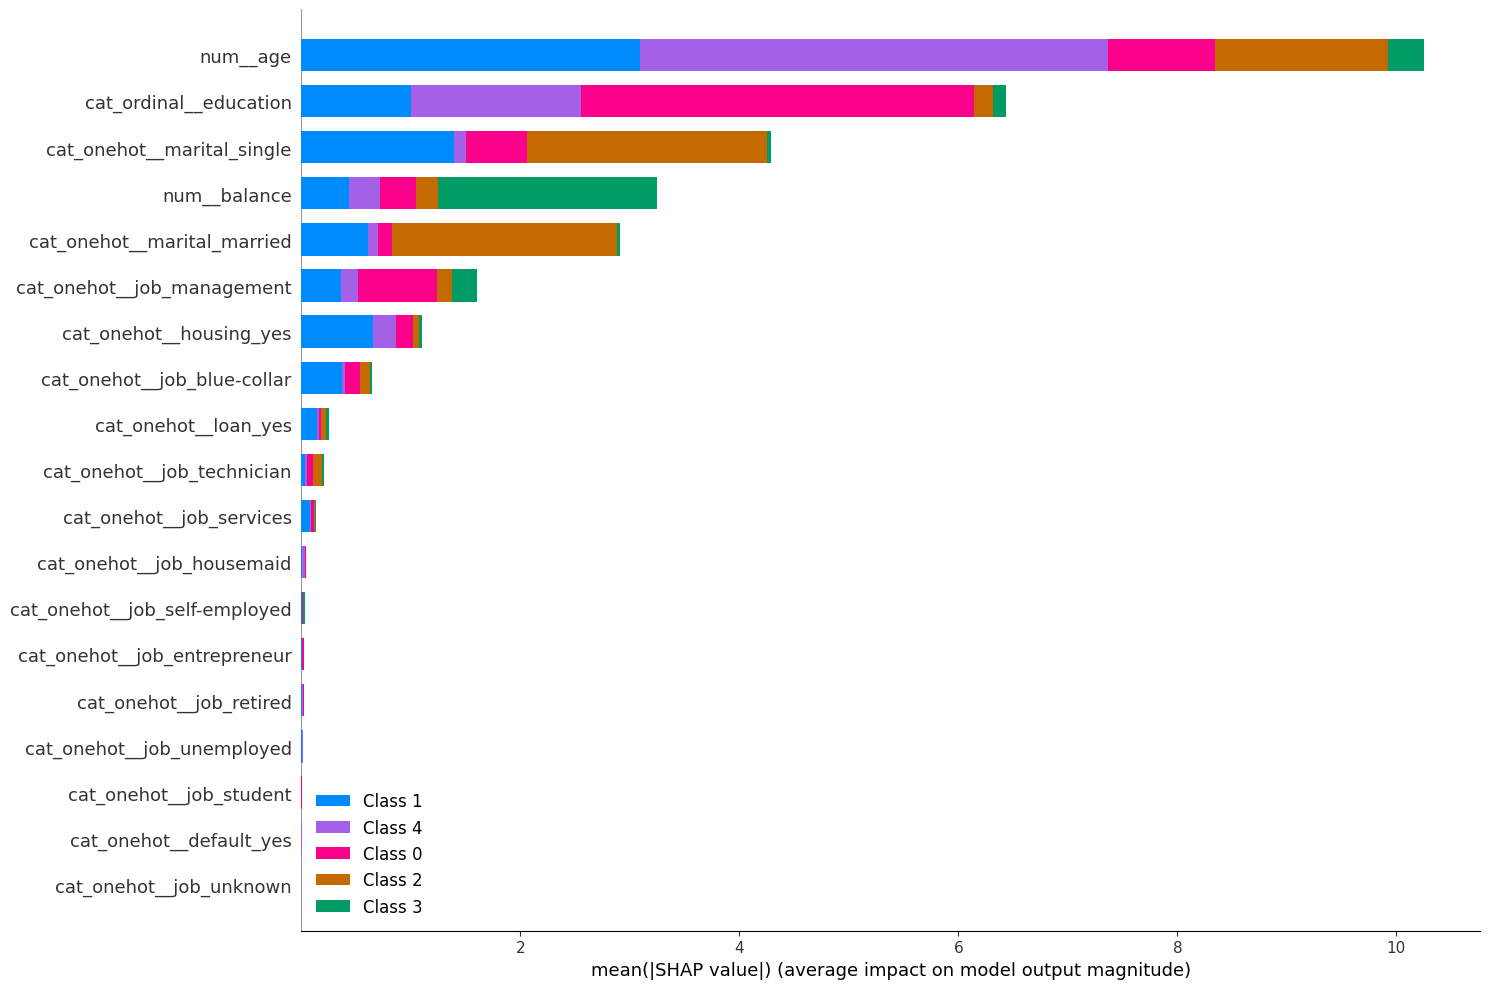

In [15]:
# We create the LGBMClassifier model and train it
clf_km = lgb.LGBMClassifier(colsample_by_tree=0.8)
clf_km.fit(X=data_no_outliers, y=clusters_predict)

# SHAP values
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(data_no_outliers)

shap.summary_plot(shap_values_km, data_no_outliers, plot_type="bar", plot_size=(15, 10))

In [22]:
df_no_outliers["cluster"] = clusters_predict

df_no_outliers.groupby('cluster').agg(
    {
        'job': lambda x: x.value_counts().index[0],
        'marital': lambda x: x.value_counts().index[0],
        'education': lambda x: x.value_counts().index[0],
        'housing': lambda x: x.value_counts().index[0],
        'loan': lambda x: x.value_counts().index[0],
        'age':'mean',
        'balance': 'mean',
        'default': lambda x: x.value_counts().index[0],
        
    }
).reset_index()

cluster          job  marital  education housing loan        age  \
0        0   management  married   tertiary      no   no  43.740556   
1        1  blue-collar  married  secondary     yes   no  34.584789   
2        2   technician   single  secondary     yes   no  32.069443   
3        3   management  married  secondary     yes   no  42.145910   
4        4  blue-collar  married  secondary      no   no  50.235083   

       balance default  
0   873.011096      no  
1   591.974043      no  
2   793.211272      no  
3  7532.461159      no  
4   838.415965      no